In [1]:
# import warnings
# warnings.filterwarnings('ignore')
import os.path

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="darkgrid")

SOURCE_DATA_PATH = 'source_data'
DERIVED_DATA_PATH = 'derived_data'

##Data Prep

Below we're going to join the needs and wellness domains, as it's our intended feature space.

In [2]:
needs = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_needs.csv'), na_values=' ', index_col='ID')
wellness = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_wellness.csv'), na_values=' ', index_col='ID')

km_X = needs.join(wellness).dropna() 

In [3]:
print 'data retention post-drop: {:.2%} percent.'.format(float(len(km_X))/len(needs))
print '# records retention post-drop: {}'.format(len(km_X))

data retention post-drop: 69.73% percent.
# records retention post-drop: 211646


So that's not bad.  Let's keep going with our cluster analysis by building our model.

##Building Model

In [4]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

It'll make most sense for us to run the model over several k's to arrive at the optimal k for our data.  To evaluate cluster validity we're going to consider two metrics: the Silhouette Coefficient & our old friend Sum of Squared Errors.  We don't get SSE out of the box with sklearn so we'll write our own.  Let's do that first.

**Sum of Squared Errors Definition:**

$$
SSE = \displaystyle\sum_{i=1}^{K}\sum_{x \in C_i} d(x, c_i)^2
$$

Now implementation...

In [5]:
#SSE get_cluster_centers helper function
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        #get mean coordinates of each cluster
        CC_list.append(np.mean(X[labels ==k], axis=0))
    return CC_list

#main SSE function
#for each cluster subtract the mean from each data point to get the error
#then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X,labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)   

In [6]:
km_X = km_X.sample(n=10000, random_state=1)

In [11]:
k_range = range(2,10)

Here we'll run "k_range" models with k clusters.

In [21]:
#@Ceslee: Check to make sure SC/SSE incongruence isn't due to data dist.
#@Ceslee: Replace sampling with full dataset if you can.
#@Ceslee: Try silhouette coefficient visualization from scikitlearn if that helps.
#@Ceslee: Why is timeit not working?
#@Ceslee: write out SC formula too
time = %timeit

SSEs = []
Sil_coefs = []

for k in k_range:
    #instantiate KMeans object
    km = KMeans(n_clusters=k, random_state=1)
    #fit model to training data
    km.fit(km_X)
    labels = km.labels_
    #store SC & SSE scores for each k run
    Sil_coefs.append(metrics.silhouette_score(km_X, labels, metric='euclidean'))
    SSEs.append(get_SSE(km_X, labels))

print time

KeyboardInterrupt: 

Let's plot the SSE and SC to see where our optimum k lies.

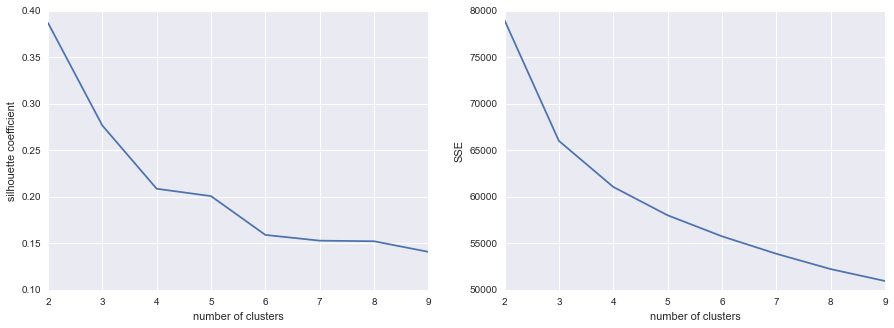

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
ax1.plot(k_range, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_range, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

On interpreting the Average Silhouette Coefficient from [sckit-learn.org](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html): 
> Silhoette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Interestingly, to maximize SC our plot indicates we should choose k=2 and to minimize SSE (and try to minimize # clusters to min. comp time and support human intuition) our plot indicates we should choose k=3.  I'm a fan of trying both to see how it affects possible interpretations later on.

In [19]:
cols = {}

for k in [2,3]:
    #instantiate KMeans model
    km = KMeans(n_clusters=k, random_state=1)
    #fit model to training data
    km.fit(km_X)
    col_name = 'segment_k_' + str(k)
    #predict classes for km_X
    #new df from index + predicted class
    cols[col_name] = km.predict(km_X)

km_index = km_X.index.values.tolist()
ID_to_kmsegment = pd.DataFrame(cols, index=km_index)    

To keep track of beneficiary segment membership I've just made a little key for later analysis.  Each record included in clustering (aka was not na/dropped) corresponds to a k=2 cluster and a k=3 cluster.

In [20]:
ID_to_kmsegment.head()

,segment_k_2,segment_k_3
C16267634,1,2
C16194877,0,0
C16129389,0,0
C14189812,1,2
C16216266,1,0


##Segment Profile Analysis

In [15]:
profile = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_profile.csv'), na_values=' ', index_col='ID')

In [24]:
profile_seg = pd.concat([profile, ID_to_kmsegment], axis=1, join='inner')
profile_seg.head()

,AGE,RACE,GENDER,MARITALSTAT,EDUCATION,REGION,LANGUAGE,OBESE,SMOKER,DEPRESSION,MCC,AT-RISK,CC-NEED,segment_k_2,segment_k_3
C16267634,65 to 74,White,M,Married,Greater than HS/GED,Region 5 (Chicago),English,Not obese (BMI < 30),0,1,4,True,True,1,2
C16194877,65 to 74,NaN,F,Non-Married,HS/GED,Region 4 (Atlanta),Spanish,Not obese (BMI < 30),0,1,5,True,True,0,0
C16129389,<65,Black,M,Non-Married,HS/GED,Region 7 (Kansas City),English,Not obese (BMI < 30),0,0,3,True,True,0,0
C14189812,>74,White,F,Married,Less than HS/GED,Region 5 (Chicago),English,Obese (BMI ≥ 30),0,1,2,True,False,1,2
C16216266,<65,White,M,Non-Married,Less than HS/GED,Region 5 (Chicago),English,Obese (BMI ≥ 30),0,0,6,True,True,1,0
